# Translate signal in MRS band 1B to band 3A
In this notebook we use the DISTORTION maps to translate the signal of a point source observation in band 1B to the half of the detector belonging to MRS band 3A. This is done by interpolating the signal of band 1B and then using the alpha distortion map to do the signal mapping.

In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.convolution import convolve
from scipy import fftpack
import scipy.interpolate as scp_interpolate
from astropy.io import fits
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# MRS spectral bands and detector pixel dimensions
bands = ["1B","3A"]

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'
MRSWaveCalDir = workDir+"MRSWaveCal/" 
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'
MrsFilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

In [4]:
psffits_band1B = funcs.get_cdps('1B',cdpDir,output='img')[3]
psffits_band3A = funcs.get_cdps('3A',cdpDir,output='img')[3]

psfdata_band1B = psffits_band1B[1].data
psfdata_band3A = psffits_band3A[1].data

# band 1B
CRPIX1_band1B = psffits_band1B[1].header['CRPIX1']
CRVAL1_band1B = psffits_band1B[1].header['CRVAL1']
CRDELT1_band1B = psffits_band1B[1].header['CDELT1']

CRPIX2_band1B = psffits_band1B[1].header['CRPIX2']
CRVAL2_band1B = psffits_band1B[1].header['CRVAL2']
CRDELT2_band1B = psffits_band1B[1].header['CDELT2']

alphas_band1B = (np.arange(psfdata_band1B.shape[1])-CRPIX1_band1B)*CRDELT1_band1B + CRVAL1_band1B
betas_band1B = (np.arange(psfdata_band1B.shape[1])-CRPIX2_band1B)*CRDELT2_band1B + CRVAL2_band1B

# band 3A
CRPIX1_band3A = psffits_band3A[1].header['CRPIX1']
CRVAL1_band3A = psffits_band3A[1].header['CRVAL1']
CRDELT1_band3A = psffits_band3A[1].header['CDELT1']

CRPIX2_band3A = psffits_band3A[1].header['CRPIX2']
CRVAL2_band3A = psffits_band3A[1].header['CRVAL2']
CRDELT2_band3A = psffits_band3A[1].header['CDELT2']

alphas_band3A = (np.arange(psfdata_band3A.shape[1])-CRPIX1_band3A)*CRDELT1_band3A + CRVAL1_band3A
betas_band3A = (np.arange(psfdata_band3A.shape[1])-CRPIX2_band3A)*CRDELT2_band3A + CRVAL2_band3A

<IPython.core.display.Javascript object>


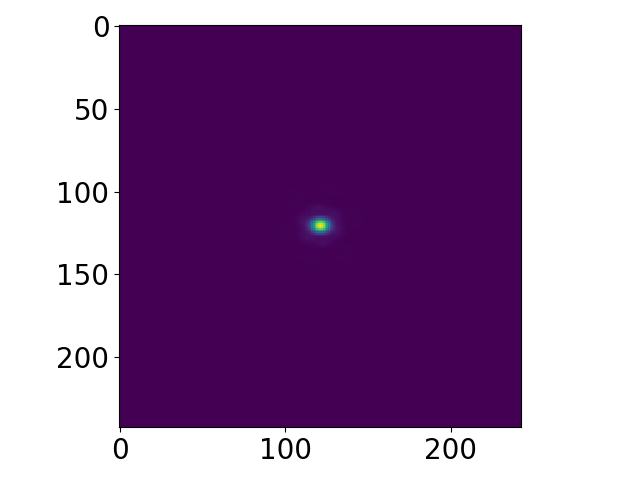

<IPython.core.display.Javascript object>


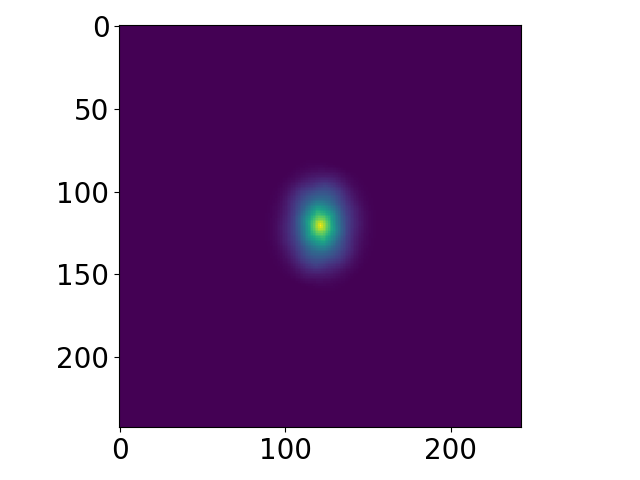

<IPython.core.display.Javascript object>


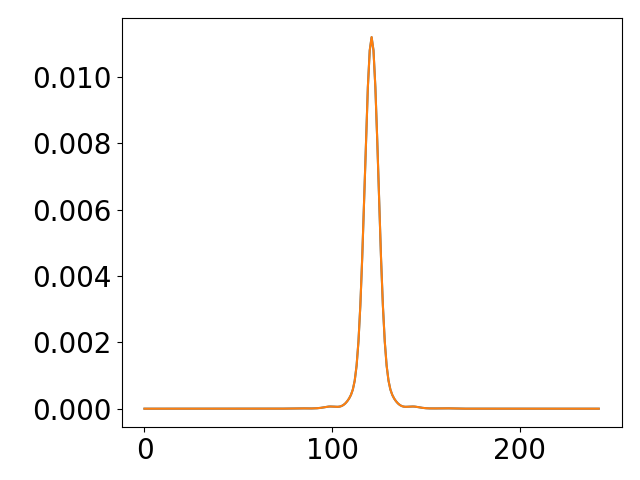

<IPython.core.display.Javascript object>


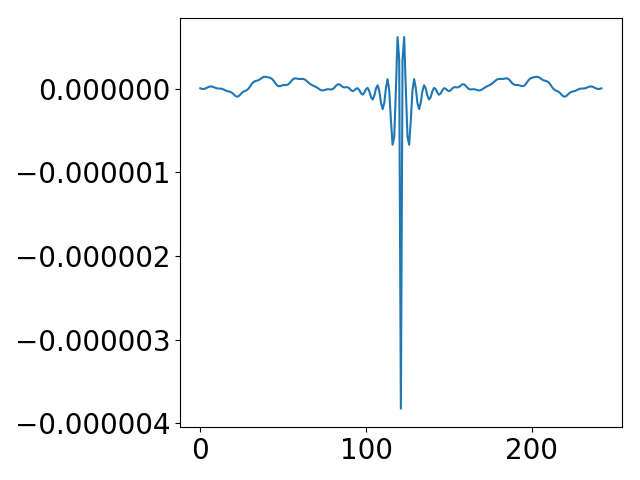

In [5]:
import scipy.fftpack
norm_psf_band1B = psfdata_band1B[100,:,:].copy()
norm_psf_band1B = norm_psf_band1B/np.sum(norm_psf_band1B)

npix_band1B = norm_psf_band1B.shape[1]
xform = np.fft.fft2(norm_psf_band1B)
norm = np.abs(xform)
shiftedY = np.roll(norm,npix_band1B/2,0)
shiftedX = np.roll(shiftedY,npix_band1B/2,1)

plt.figure()
plt.imshow(norm_psf_band1B)
plt.tight_layout()

plt.figure()
plt.imshow(shiftedX)
plt.tight_layout()

fourier_transform_psf_band1B = shiftedX

# check if inverse fourier transform of fourier transform of original psf yields original psf
inverse_fourier = np.fft.ifft2(fourier_transform_psf_band1B)
norm = np.abs(inverse_fourier)
shiftedY = np.roll(norm,npix_band1B/2,0)
shiftedX = np.roll(shiftedY,npix_band1B/2,1)

plt.figure()
plt.plot(norm_psf_band1B[npix_band1B/2,:])
plt.plot(shiftedX[npix_band1B/2,:])
plt.tight_layout()

plt.figure()
plt.plot(norm_psf_band1B[npix_band1B/2,:]-shiftedX[npix_band1B/2,:])
plt.tight_layout()

(243, 243)


<IPython.core.display.Javascript object>


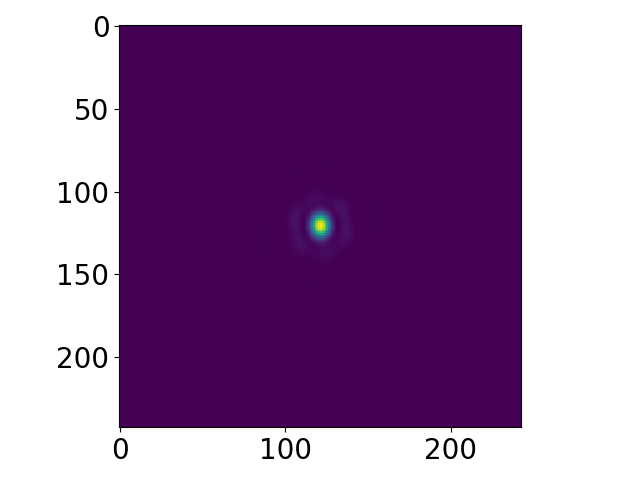

<IPython.core.display.Javascript object>


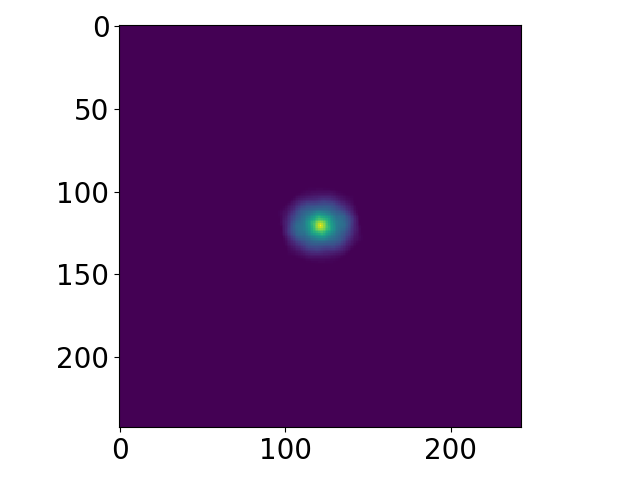

In [6]:
norm_psf_band3A = psfdata_band3A[100,:,:]
npix_band3A = norm_psf_band3A.shape[1]
norm_psf_band3A = norm_psf_band3A[npix_band3A/2-npix_band1B/2:npix_band3A/2+npix_band1B/2+1,npix_band3A/2-npix_band1B/2:npix_band3A/2+npix_band1B/2+1]
norm_psf_band3A = norm_psf_band3A/np.sum(norm_psf_band3A)

print norm_psf_band3A.shape

npix_band3A = norm_psf_band3A.shape[1]
xform = np.fft.fft2(norm_psf_band3A)
norm = np.abs(xform)
shiftedY = np.roll(norm,npix_band3A/2,0)
shiftedX = np.roll(shiftedY,npix_band3A/2,1)

plt.figure()
plt.imshow(norm_psf_band3A)
plt.tight_layout()

plt.figure()
plt.imshow(shiftedX)
plt.tight_layout()

fourier_transform_psf_band3A = shiftedX

<IPython.core.display.Javascript object>


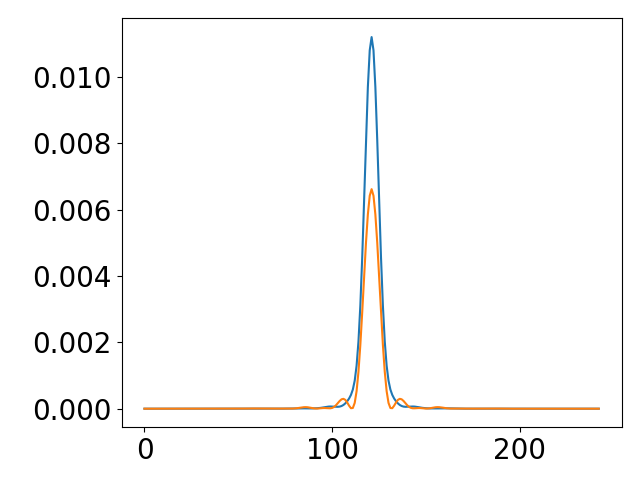

<IPython.core.display.Javascript object>


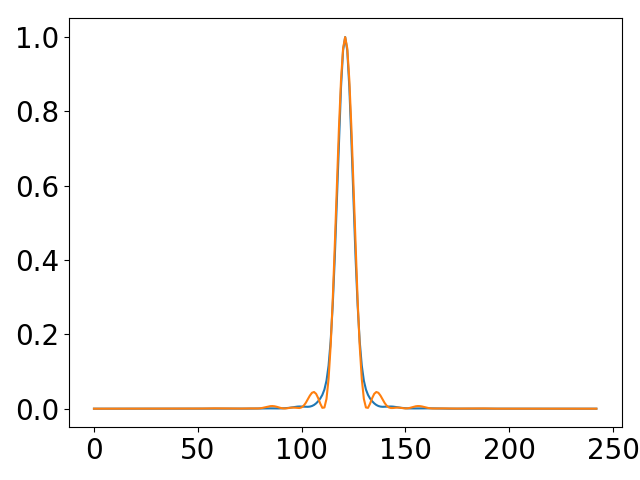

<IPython.core.display.Javascript object>


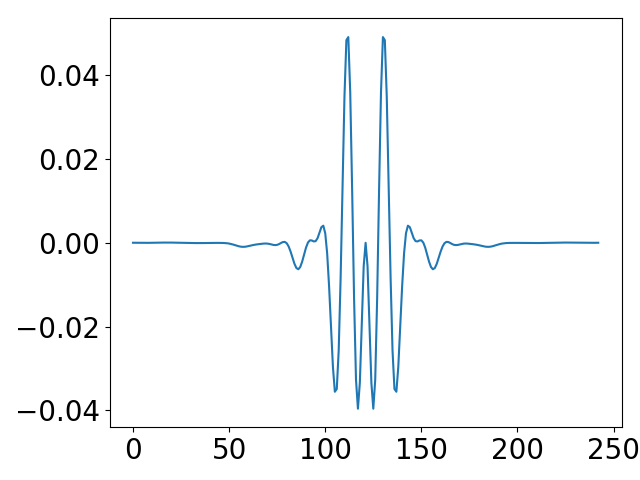

In [27]:
# compare the two normalized PSFs
plt.figure()
plt.plot(norm_psf_band1B[norm_psf_band1B.shape[0]/2,:])
plt.plot(norm_psf_band3A[norm_psf_band1B.shape[0]/2,:])
plt.tight_layout()

plt.figure()
plt.plot(norm_psf_band1B[norm_psf_band1B.shape[0]/2,:]/np.max(norm_psf_band1B[norm_psf_band1B.shape[0]/2,:]))
plt.plot(norm_psf_band3A[norm_psf_band1B.shape[0]/2,:]/np.max(norm_psf_band3A[norm_psf_band1B.shape[0]/2,:]))
plt.tight_layout()


new = (norm_psf_band1B[norm_psf_band1B.shape[0]/2,:]/np.max(norm_psf_band1B[norm_psf_band1B.shape[0]/2,:]))
old = (norm_psf_band3A[norm_psf_band1B.shape[0]/2,:]/np.max(norm_psf_band3A[norm_psf_band1B.shape[0]/2,:]))
plt.figure()
plt.plot( new-old )
plt.plot()
plt.tight_layout()

<IPython.core.display.Javascript object>


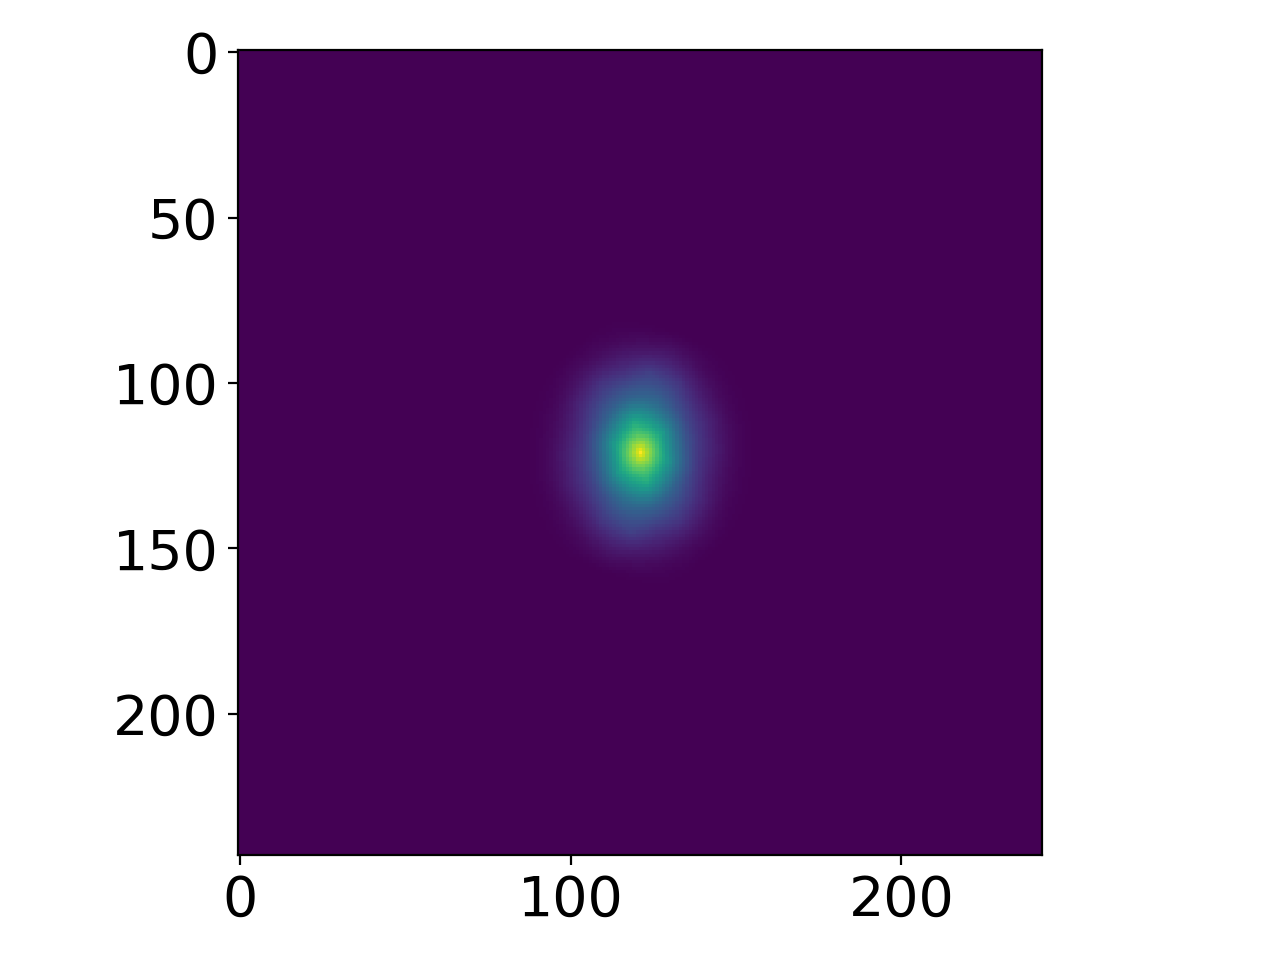

24.3220076407 17.0254053485


<IPython.core.display.Javascript object>


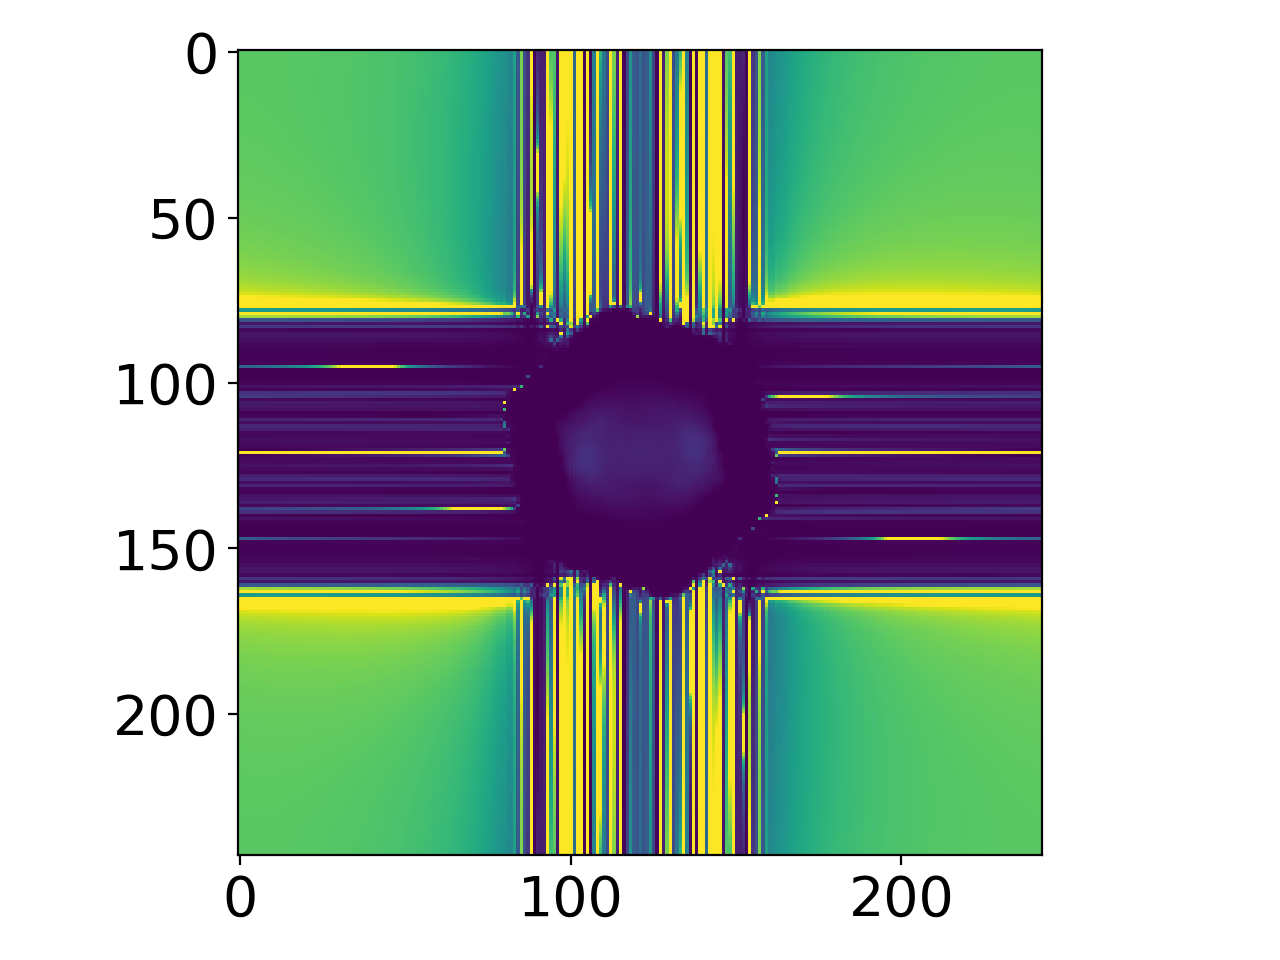

<IPython.core.display.Javascript object>


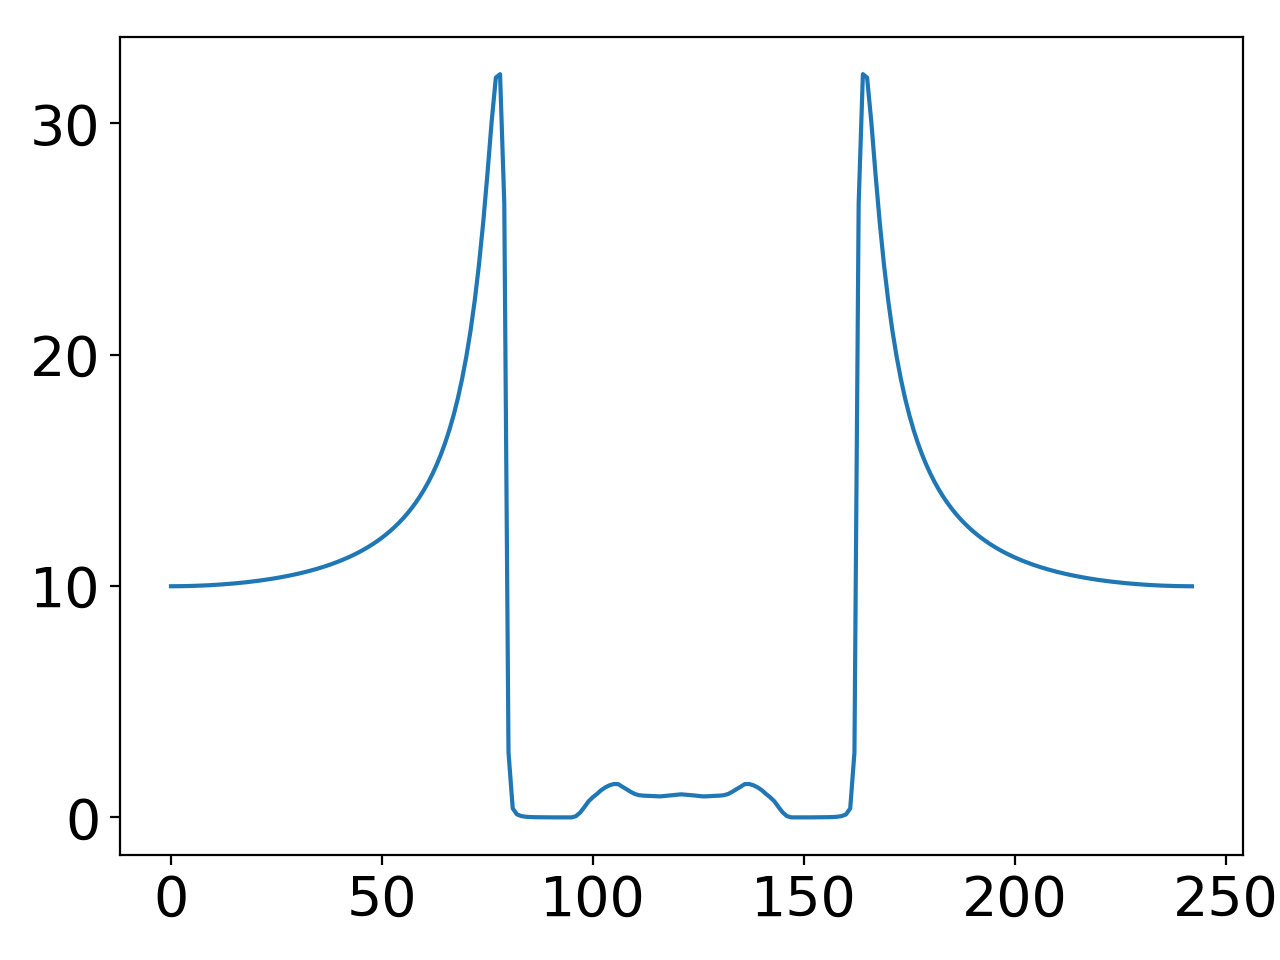

<IPython.core.display.Javascript object>


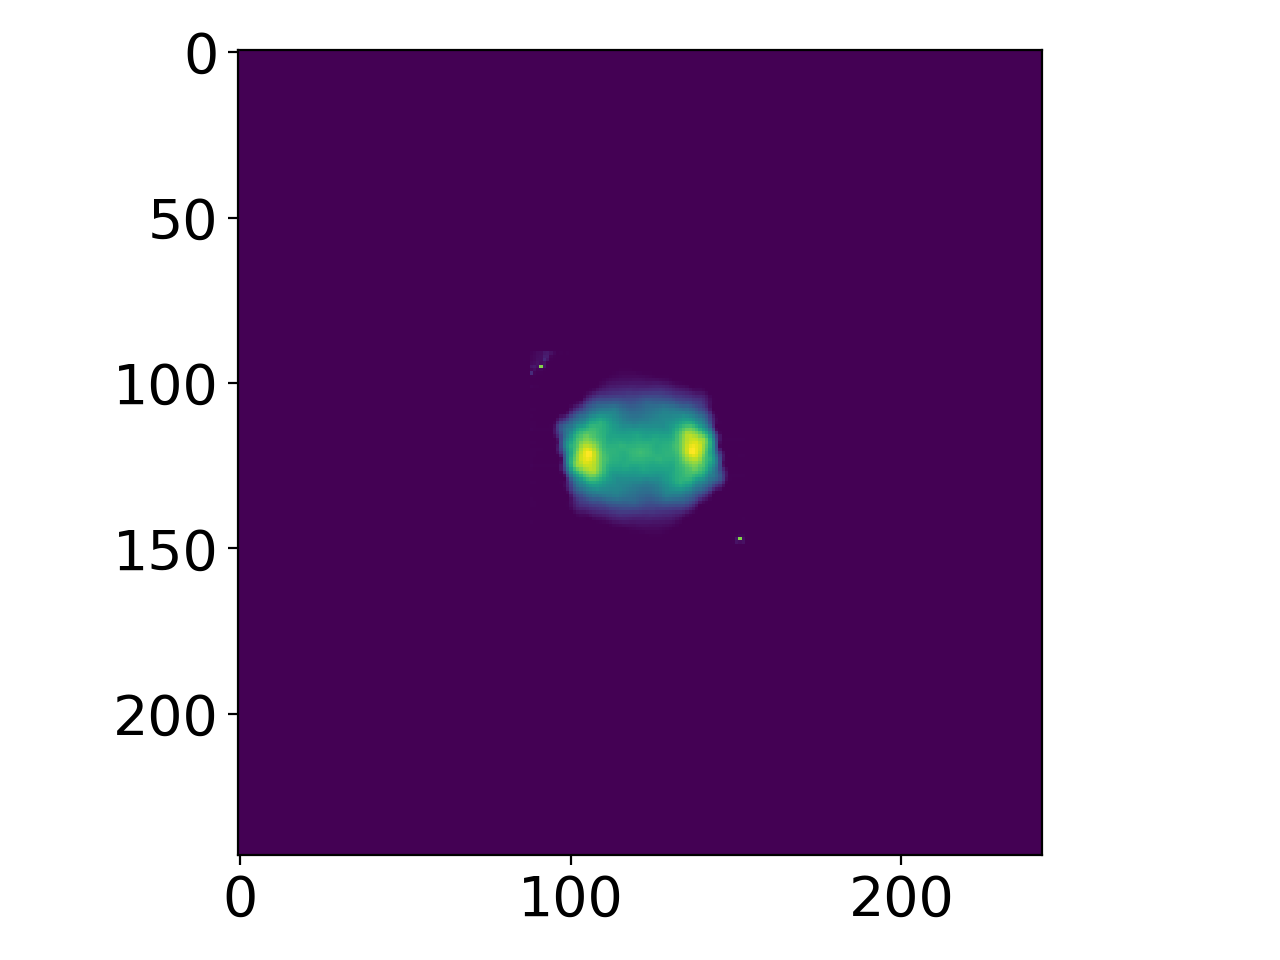

In [74]:
# multiply fourier transforms of psfs

plt.figure()
plt.imshow(fourier_transform_psf_band1B)
plt.tight_layout()

FWHM_A = 0.31 # arcsec
k_A = 1.2
k_H_A = k_A * (2 * np.pi)/FWHM_A
k_L_A = 0.7*k_H_A
print k_H_A,k_L_A
spatial_frequency = fourier_transform_psf_band3A/fourier_transform_psf_band1B
f_A = np.zeros(spatial_frequency.shape)

plt.figure()
plt.imshow(spatial_frequency,vmin=0,vmax=10)
plt.tight_layout()

plt.figure()
plt.plot(spatial_frequency[121,:])
plt.tight_layout()

test = np.zeros(spatial_frequency.shape)
test[91:149,88:153] = spatial_frequency[91:149,88:153]

# f_A[spatial_frequency>=k_H_A] = 0
# f_A[spatial_frequency<=k_L_A] = 1
# f_A[(spatial_frequency<=k_H_A) & (spatial_frequency>=k_L_A)] = 0.5 * (1 + np.cos(np.pi * (spatial_frequency[(spatial_frequency<=k_H_A) & (spatial_frequency>=k_L_A)] - k_L_A / (k_H_A - k_L_A) )))

# plt.figure()
# plt.imshow(spatial_frequency*f_A)
# plt.tight_layout()

plt.figure()
plt.imshow(test)
plt.tight_layout()

<IPython.core.display.Javascript object>


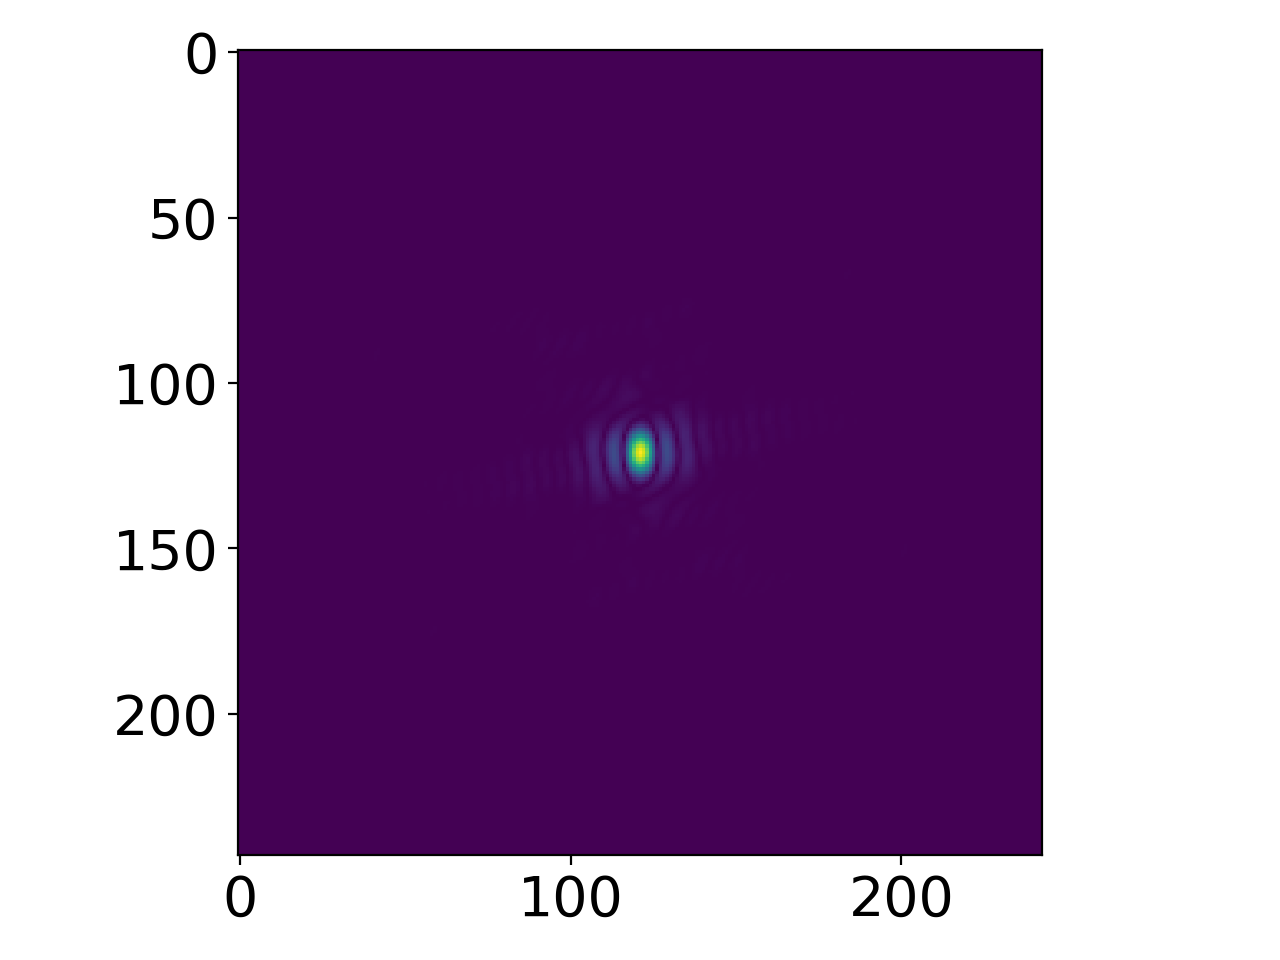

<IPython.core.display.Javascript object>


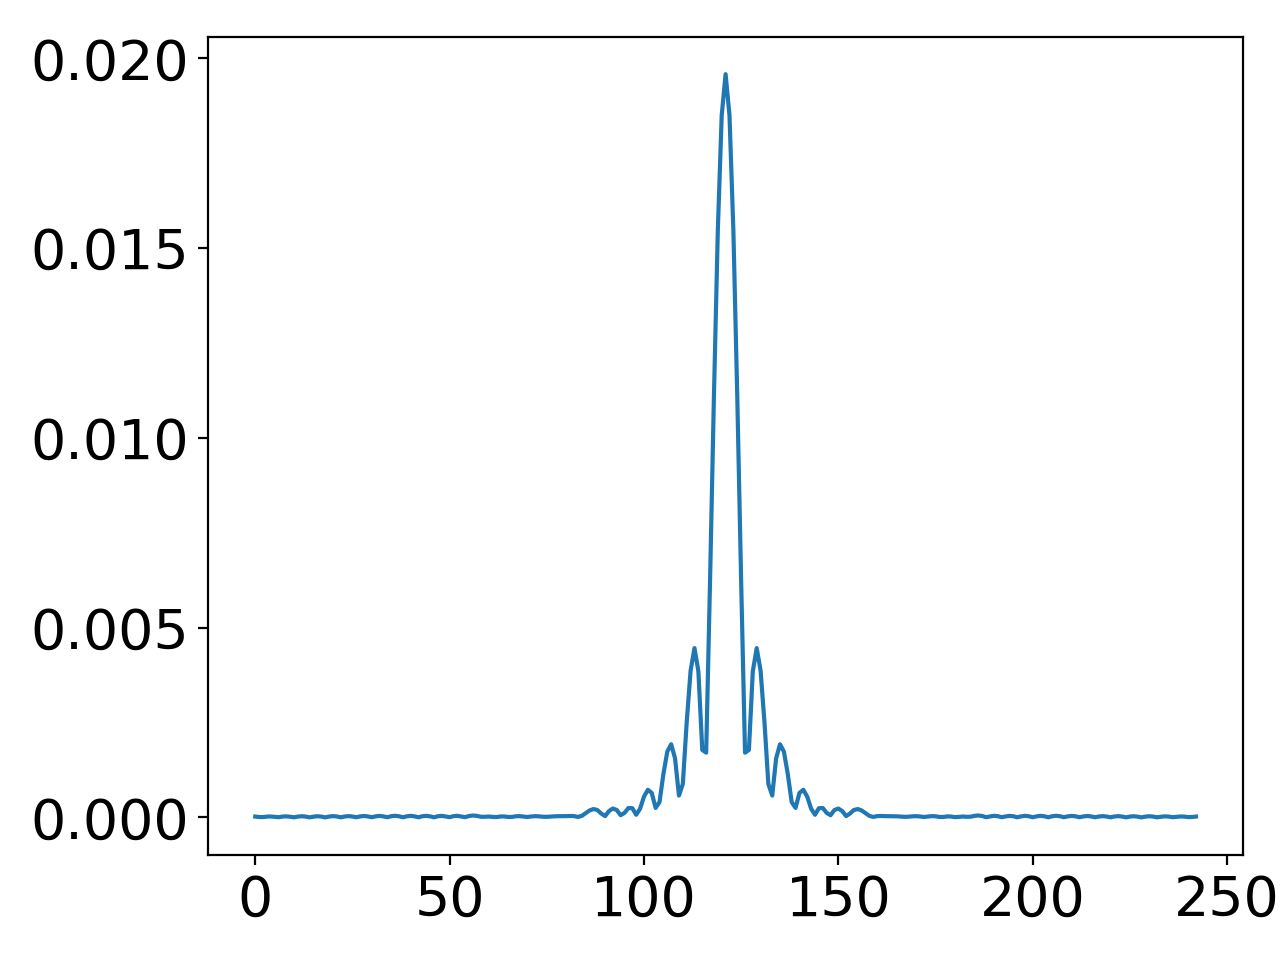

In [75]:
# take the inverse Fourier transform of the psf product
inverse_fourier_transform = np.fft.ifft2(test)

npix = inverse_fourier_transform.shape[1]
norm = np.abs(inverse_fourier_transform)
shiftedY = np.roll(norm,npix/2,0)
shiftedX = np.roll(shiftedY,npix/2,1)

plt.figure()
plt.imshow(shiftedX)
plt.tight_layout()

plt.figure()
plt.plot(shiftedX[npix/2,:])
plt.tight_layout()

kernel_band1B_to_band3A = shiftedX/np.sum(shiftedX)

<IPython.core.display.Javascript object>


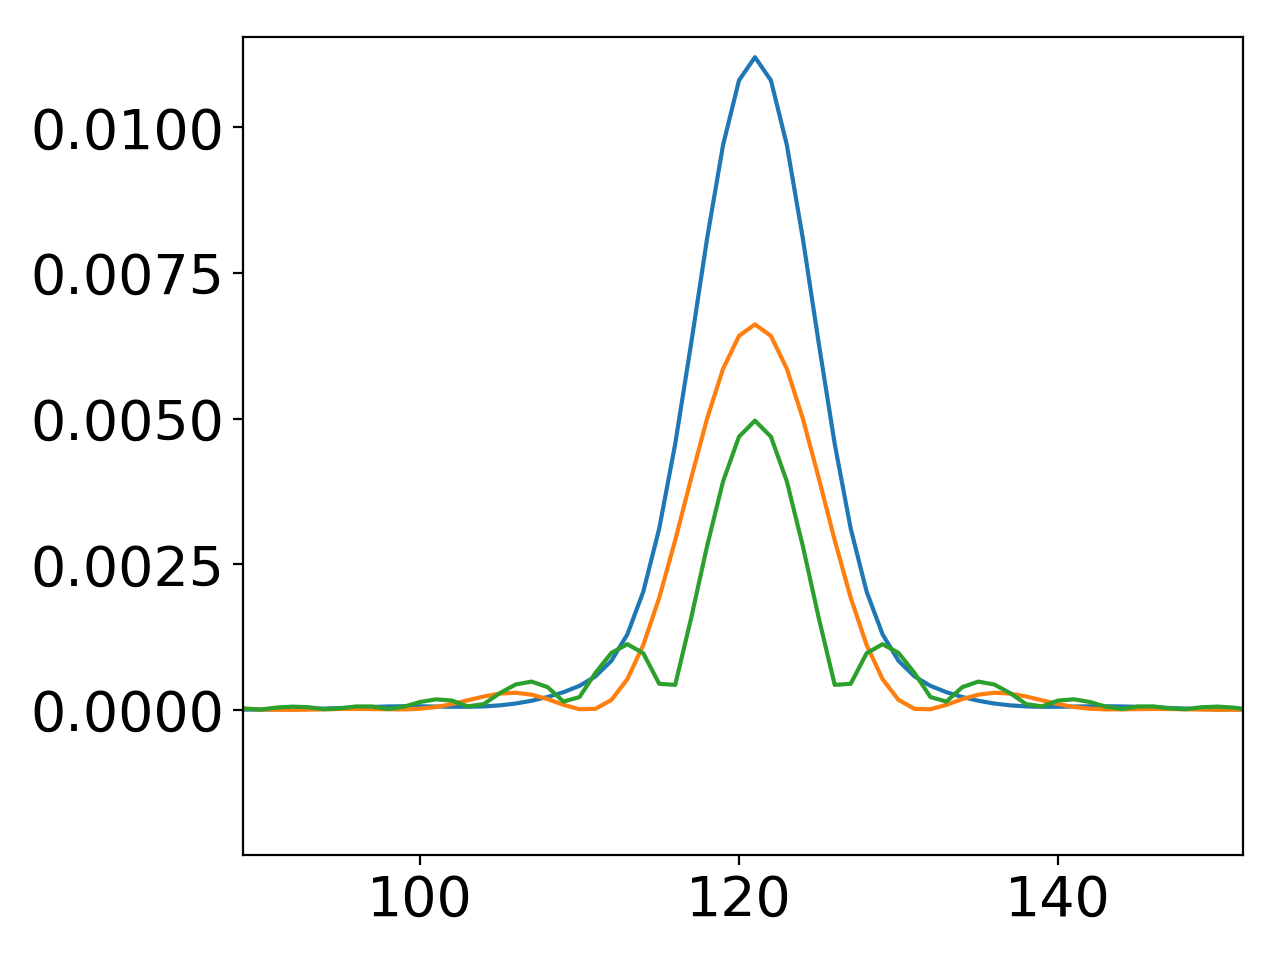

<IPython.core.display.Javascript object>


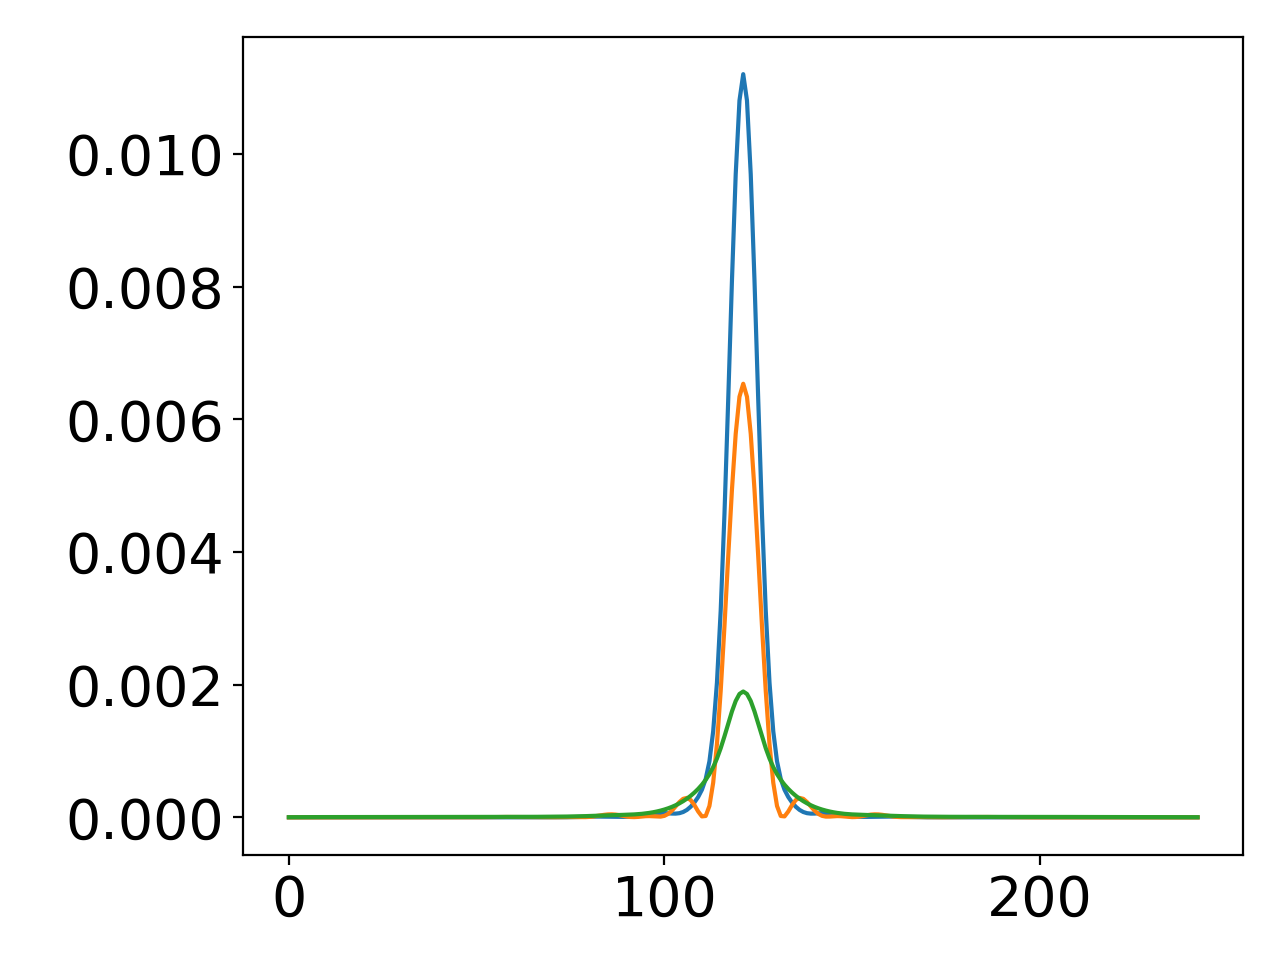

In [76]:
# convolve the PSF of band 1B with the kernel determined above
norm_kernel_band1B_to_band3A = kernel_band1B_to_band3A/np.sum(kernel_band1B_to_band3A)

plt.figure()
plt.plot(norm_psf_band1B[npix_band1B/2,:])
plt.plot(norm_psf_band3A[npix_band1B/2,:])
plt.plot(norm_kernel_band1B_to_band3A[npix_band1B/2,:])
plt.tight_layout()

from scipy import signal
# mode='same' is there to enforce the same output shape as input arrays
# (ie avoid border effects)
img = signal.fftconvolve(norm_psf_band1B,norm_kernel_band1B_to_band3A, mode='same')

plt.figure()
plt.plot(norm_psf_band1B[npix_1B/2,:])
plt.plot(norm_psf_band3A_cropped[npix_1B/2,:])
plt.plot(img[npix_1B/2,:])
plt.tight_layout()

In [56]:
print np.linspace(-10, 10.5, 200)
print alphas_band1B

[ -1.00000000e+01  -9.89698492e+00  -9.79396985e+00  -9.69095477e+00
  -9.58793970e+00  -9.48492462e+00  -9.38190955e+00  -9.27889447e+00
  -9.17587940e+00  -9.07286432e+00  -8.96984925e+00  -8.86683417e+00
  -8.76381910e+00  -8.66080402e+00  -8.55778894e+00  -8.45477387e+00
  -8.35175879e+00  -8.24874372e+00  -8.14572864e+00  -8.04271357e+00
  -7.93969849e+00  -7.83668342e+00  -7.73366834e+00  -7.63065327e+00
  -7.52763819e+00  -7.42462312e+00  -7.32160804e+00  -7.21859296e+00
  -7.11557789e+00  -7.01256281e+00  -6.90954774e+00  -6.80653266e+00
  -6.70351759e+00  -6.60050251e+00  -6.49748744e+00  -6.39447236e+00
  -6.29145729e+00  -6.18844221e+00  -6.08542714e+00  -5.98241206e+00
  -5.87939698e+00  -5.77638191e+00  -5.67336683e+00  -5.57035176e+00
  -5.46733668e+00  -5.36432161e+00  -5.26130653e+00  -5.15829146e+00
  -5.05527638e+00  -4.95226131e+00  -4.84924623e+00  -4.74623116e+00
  -4.64321608e+00  -4.54020101e+00  -4.43718593e+00  -4.33417085e+00
  -4.23115578e+00  -4.12814070e+00

<IPython.core.display.Javascript object>


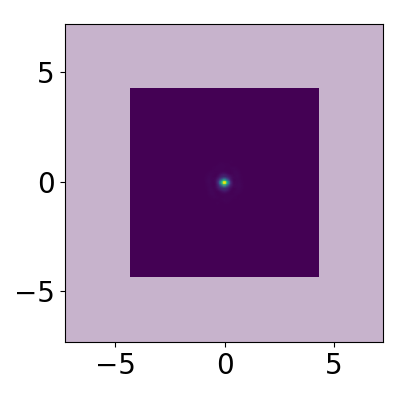

<IPython.core.display.Javascript object>


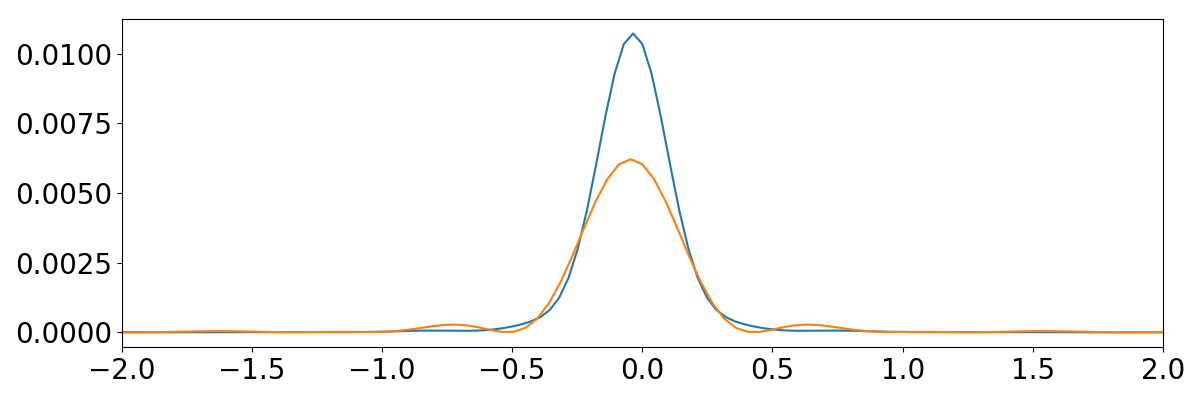

<IPython.core.display.Javascript object>


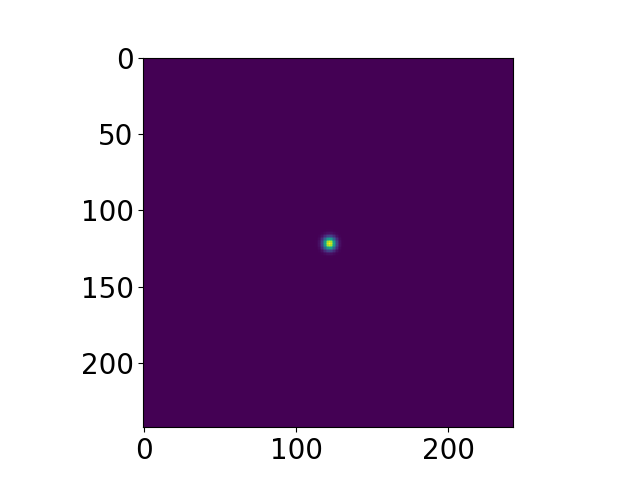

<IPython.core.display.Javascript object>


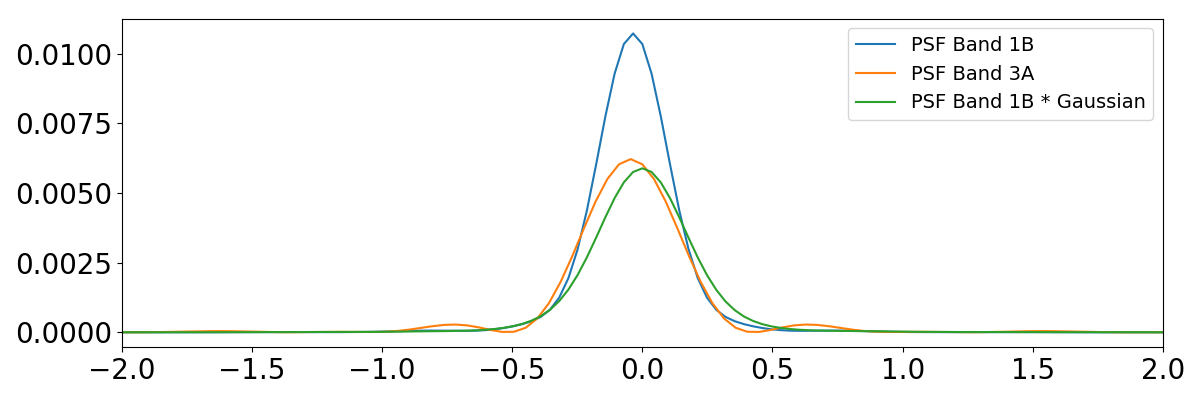

<IPython.core.display.Javascript object>


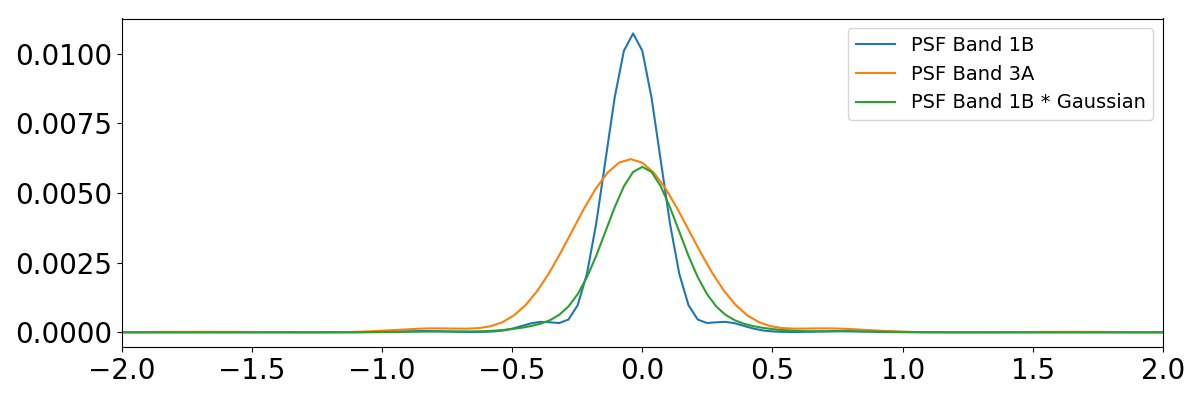

0.95753982987
0.951090098815
0.95721230443


In [63]:
plt.figure(figsize=(4,4))
plt.imshow(psfdata_band1B[100,:,:],vmin=0,vmax=psfdata_band1B[100,:,:].max(),extent=(alphas_band1B[0],alphas_band1B[-1],betas_band1B[0],betas_band1B[-1]))
plt.imshow(psfdata_band3A[100,:,:],vmin=0,vmax=psfdata_band3A[100,:,:].max(),extent=(alphas_band3A[0],alphas_band3A[-1],betas_band3A[0],betas_band3A[-1]),alpha=0.3)
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(alphas_band1B,psfdata_band1B[100,psfdata_band1B.shape[2]/2,:])
plt.plot(alphas_band3A,psfdata_band3A[100,psfdata_band3A.shape[2]/2,:])
plt.xlim(-2,2)
plt.tight_layout()


img = psfdata_band1B[100,:,:]
# First a 1-D  Gaussian
t = np.linspace(-10, 10.5, 200)
t = alphas_band1B.copy()
bump = np.exp(-50*t**2)
bump /= np.trapz(bump) # normalize the integral to 1

# make a 2-D kernel out of it
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]

plt.figure()
plt.imshow(kernel)

from scipy import signal
# mode='same' is there to enforce the same output shape as input arrays
# (ie avoid border effects)
img2 = signal.fftconvolve(img, kernel, mode='same')

# plt.figure()
# plt.imshow(kernel)
# plt.tight_layout()

# # Padded fourier transform, with the same shape as the image
# # We use :func:`scipy.signal.fftpack.fft2` to have a 2D FFT
# kernel_ft = fftpack.fft2(kernel, shape=img.shape[:2], axes=(0, 1))

# # convolve
# img_ft = fftpack.fft2(img, axes=(0, 1))
# # the 'newaxis' is to match to color direction
# img2_ft = kernel_ft[:, :, np.newaxis] * img_ft
# img2 = fftpack.ifft2(img2_ft, axes=(0, 1)).real

# # clip values to range
# img2 = np.clip(img2, 0, 1)

# # plot output
# plt.figure()
# plt.imshow(img2)

plt.figure(figsize=(12,4))
plt.plot(alphas_band1B,psfdata_band1B[100,psfdata_band1B.shape[2]/2,:],label='PSF Band 1B')
plt.plot(alphas_band3A,psfdata_band3A[100,psfdata_band3A.shape[2]/2,:],label='PSF Band 3A')
plt.plot(alphas_band1B,img2[psfdata_band1B.shape[2]/2,:],label='PSF Band 1B * Gaussian')
plt.xlim(-2,2)
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(alphas_band1B,psfdata_band1B[100,:,psfdata_band1B.shape[1]/2],label='PSF Band 1B')
plt.plot(alphas_band3A,psfdata_band3A[100,:,psfdata_band3A.shape[1]/2],label='PSF Band 3A')
plt.plot(alphas_band1B,img2[:,psfdata_band1B.shape[1]/2],label='PSF Band 1B * Gaussian')
plt.xlim(-2,2)
plt.legend(loc='upper right')
plt.tight_layout()

print psfdata_band1B[100,:,:].sum()
print psfdata_band3A[100,:,:].sum()
print img2.sum()

<IPython.core.display.Javascript object>


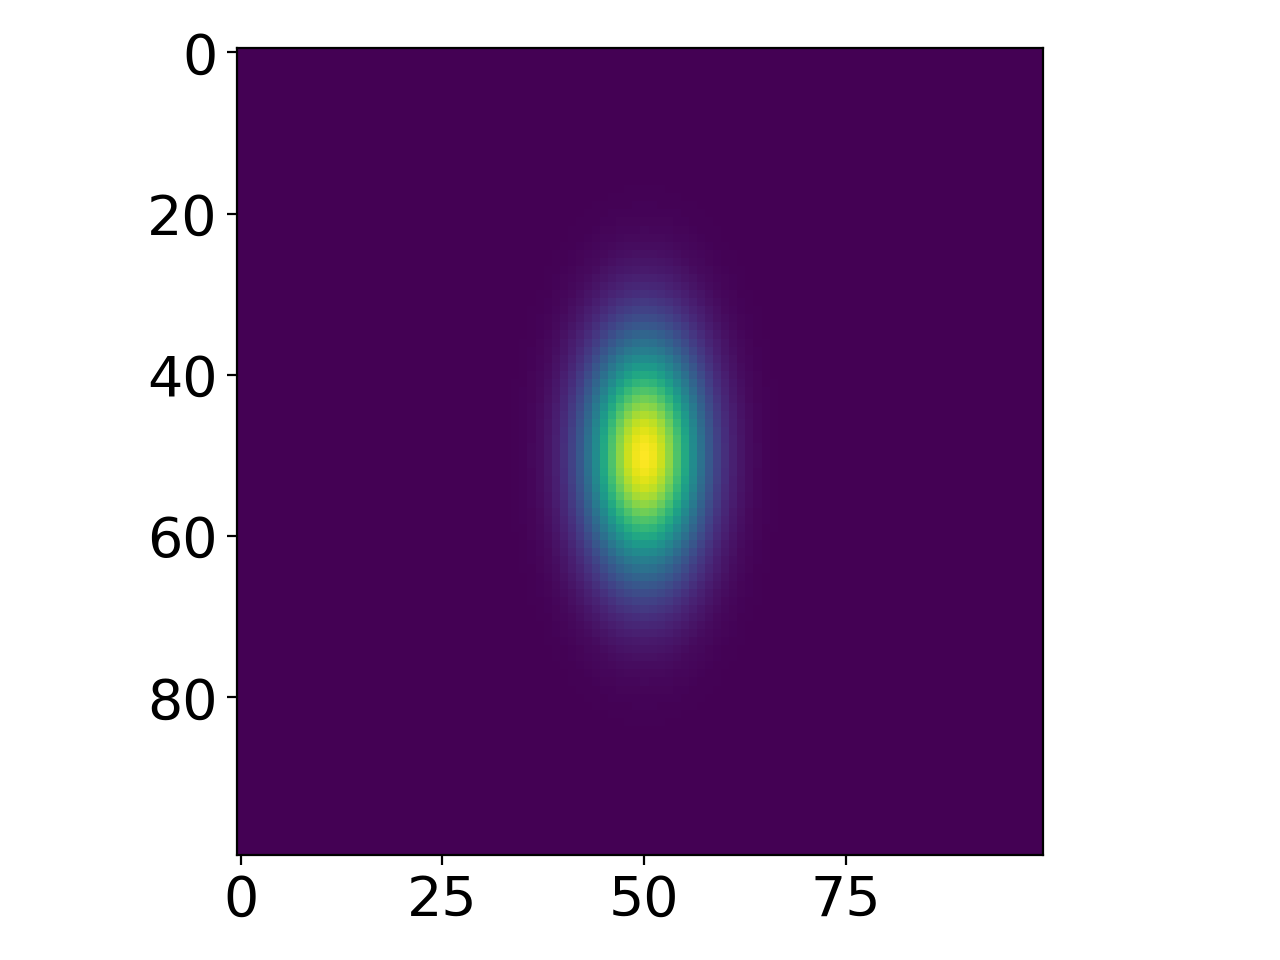

In [49]:
def gauss2d(x, y, amp, x0, y0, sigma_x, sigma_y, base):
    amp, x0, y0, sigma_x, sigma_y, base = float(amp),float(x0),float(y0),float(sigma_x),float(sigma_y),float(base)
    a = 1/(2*sigma_x**2)
    b = 1/(2*sigma_y**2)
    inner = a * (x - x0)**2
    inner += b * (y - y0)**2
    return amp * np.exp(-inner) + base

X,Y = np.meshgrid(np.arange(100),np.arange(100))

test = gauss2d(X,Y,10,50,50,5,10,10)

plt.figure()
plt.imshow(test)
plt.tight_layout()

In [5]:
point_source_bkgsubtr_1B = point_source_sci_1B-point_source_bkg_1B
point_source_bkgsubtr_3A = point_source_sci_3A-point_source_bkg_3A

In [6]:
d2cMaps_1B = funcs.load_obj('d2cMaps_band1B_tr80pc',path=d2cMapDir)
d2cMaps_3A = funcs.load_obj('d2cMaps_band3A_tr80pc',path=d2cMapDir)

In [7]:
specres_table_1B = funcs.get_cdps('1B',cdpDir)[4]
specres_table_3A = funcs.get_cdps('3A',cdpDir)[4]
lambcens_1B,lambfwhms_1B = funcs.spectral_gridding('1B',d2cMaps_1B,specres_table=specres_table_1B)
lambcens_3A,lambfwhms_3A = funcs.spectral_gridding('3A',d2cMaps_3A,specres_table=specres_table_3A)

In [8]:
sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_signal = [{} for i in range(6)]

sign_amp['1B'],alpha_centers['1B'],beta_centers['1B'],sigma_alpha['1B'],sigma_beta['1B'],bkg_signal['1B'] = funcs.point_source_centroiding('1B',point_source_bkgsubtr_1B,d2cMaps_1B,spec_grid=[lambcens_1B,lambfwhms_1B],fit='2D')
sign_amp['3A'],alpha_centers['3A'],beta_centers['3A'],sigma_alpha['3A'],sigma_beta['3A'],bkg_signal['3A'] = funcs.point_source_centroiding('3A',point_source_bkgsubtr_3A,d2cMaps_3A,spec_grid=[lambcens_3A,lambfwhms_3A],fit='2D')

STEP 1: Rough centroiding
Slice 11 has the largest summed flux
Source position: beta = 0.0arcsec, alpha = -0.27arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 38, 39, 40, 41, 117, 118, 119, 191, 197, 287, 288, 296, 297, 298, 336, 337, 338, 361, 362, 363, 364, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582]
STEP 1: Rough centroiding
Slice 9 has the largest summed flux
Source position

In [9]:
sel_1B = np.where((d2cMaps_1B['sliceMap'] > 100*int('1')) & (d2cMaps_1B['sliceMap'] < 100*(int('1')+1) ) & (d2cMaps_1B['lambdaMap'] > 11.8/2. ) & (d2cMaps_1B['lambdaMap'] < 12.5/2. ))
sel_3A = np.where((d2cMaps_3A['sliceMap'] > 100*int('3')) & (d2cMaps_3A['sliceMap'] < 100*(int('3')+1) ) & (np.abs(d2cMaps_3A['alphaMap']) < 2. ) & (np.abs(d2cMaps_3A['betaMap']) < 2. ) & (d2cMaps_3A['lambdaMap'] > 12. ) & (d2cMaps_3A['lambdaMap'] < 12.3 ))

<IPython.core.display.Javascript object>


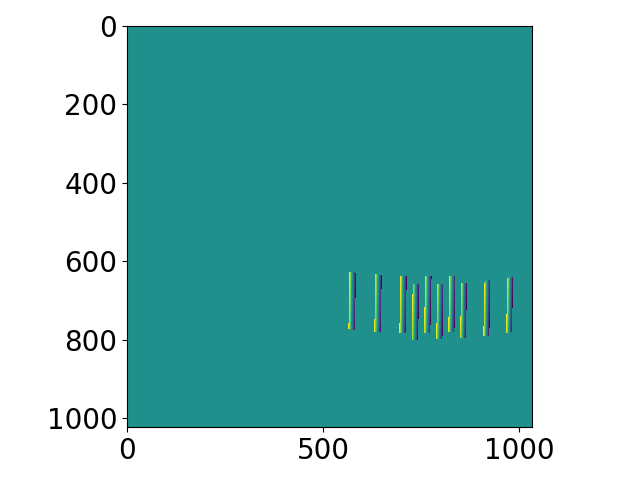

In [10]:
test_img = np.zeros((1024,1032))
test_img[sel_3A] = d2cMaps_3A['alphaMap'][sel_3A]

plt.figure()
plt.imshow(test_img)
plt.tight_layout()

In [11]:
points_alpha  = d2cMaps_1B['alphaMap'][sel_1B]
points_beta   = d2cMaps_1B['betaMap'][sel_1B]
points_lambda = d2cMaps_1B['lambdaMap'][sel_1B]*2.
values = point_source_bkgsubtr_1B[sel_1B]

In [14]:
points_alpha_3A  = np.flipud(d2cMaps_3A['alphaMap'][sel_3A])
points_beta_3A   = np.flipud(d2cMaps_3A['betaMap'][sel_3A])
points_lambda_3A = np.flipud(d2cMaps_3A['lambdaMap'][sel_3A])

In [25]:
print points_alpha_3A.min(),points_alpha_3A.max()
print points_beta_3A.min(),points_beta_3A.max()
print points_lambda_3A.min(),points_lambda_3A.max()

-1.99991597901 1.99979435895
-1.75416200248 1.75416200248
12.0000045657 12.2999981485


In [16]:
from scipy.interpolate import griddata

In [26]:
points = np.column_stack((points_alpha,points_beta,points_lambda))
points_3A = np.column_stack((points_alpha_3A,points_beta_3A,points_lambda_3A))

print points.shape
print values.shape
print points_3A.shape

interp_values = griddata(points,values,points_3A,rescale=True)

(141825, 3)
(141825,)
(22776, 3)


<IPython.core.display.Javascript object>


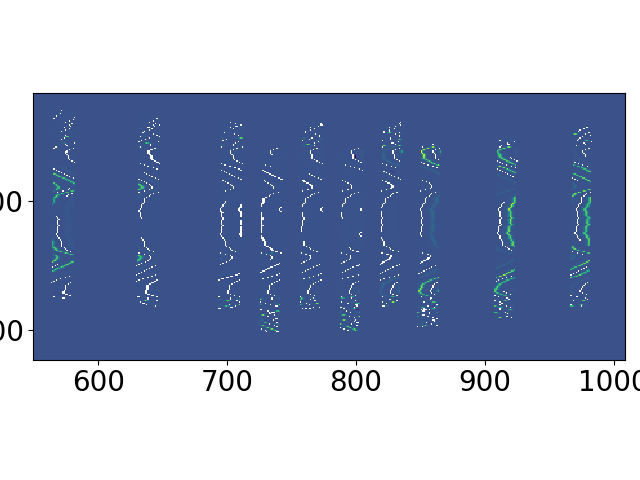

<IPython.core.display.Javascript object>


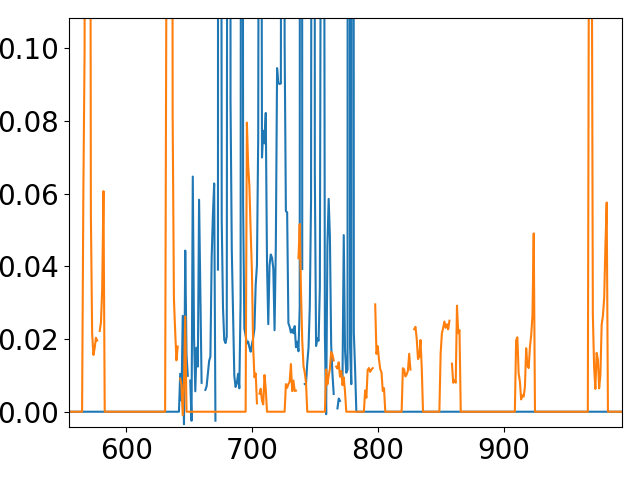

In [28]:
test_img = np.zeros((1024,1032))
test_img[sel_3A] = interp_values.copy()

plt.figure()
plt.imshow(test_img)
plt.tight_layout()

plt.figure()
plt.plot(test_img[:,976])
plt.plot(test_img[690,:])
plt.tight_layout()

In [20]:
points = np.random.rand(10, 2)
print points
print points.shape
print points[:,0], points[:,1]

[[ 0.72421953  0.46344189]
 [ 0.02708754  0.40207573]
 [ 0.65743661  0.98366348]
 [ 0.56031736  0.10812709]
 [ 0.20789223  0.65637721]
 [ 0.43645996  0.15115552]
 [ 0.04772082  0.46361108]
 [ 0.15398065  0.11167568]
 [ 0.17397742  0.22411361]
 [ 0.88608086  0.09772491]]
(10, 2)
[ 0.72421953  0.02708754  0.65743661  0.56031736  0.20789223  0.43645996
  0.04772082  0.15398065  0.17397742  0.88608086] [ 0.46344189  0.40207573  0.98366348  0.10812709  0.65637721  0.15115552
  0.46361108  0.11167568  0.22411361  0.09772491]


<IPython.core.display.Javascript object>


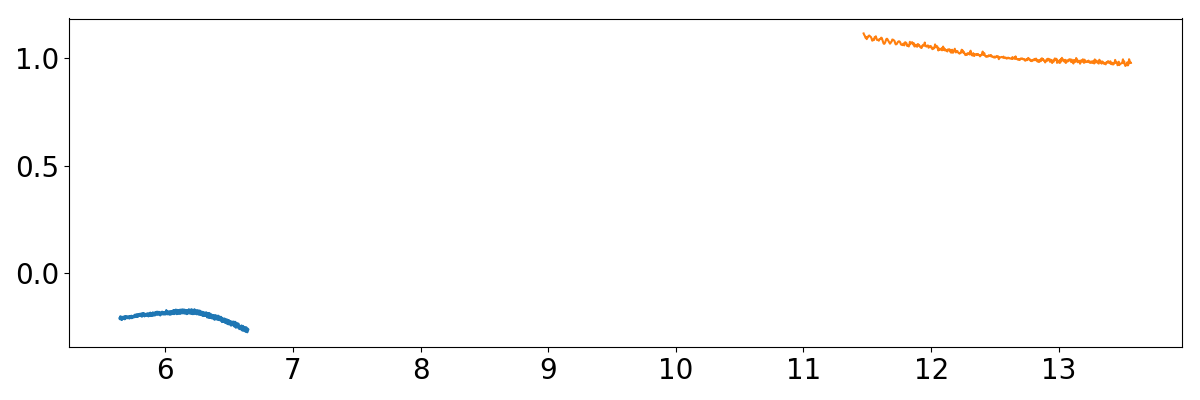

In [10]:
plt.figure(figsize=(12,4))
plt.plot(lambcens_1B,alpha_centers['1B'])
plt.plot(lambcens_3A,alpha_centers['3A'])
plt.tight_layout()

<IPython.core.display.Javascript object>


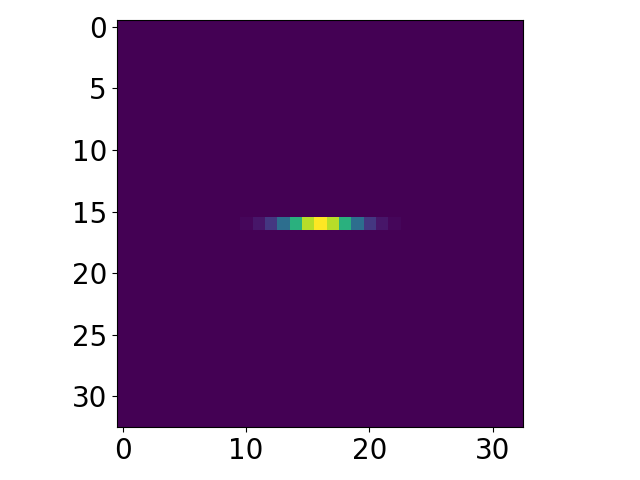

In [178]:
nx,ny = 2**4,2**4
x = np.arange(-nx, nx+1)
y = np.arange(-ny, ny+1)
xi, yi = np.meshgrid(x, y)
yxi = np.vstack([xi.ravel(), yi.ravel()])

kernel = funcs.gauss2d(yxi, 1, 0, 0, 2.1, 0.01, 0)
kernel/= kernel.sum()
kernel.shape = xi.shape

plt.figure()
plt.imshow(kernel)
plt.tight_layout()

In [179]:
degrade4 = convolve(point_source_bkgsubtr_1B, kernel)

<IPython.core.display.Javascript object>


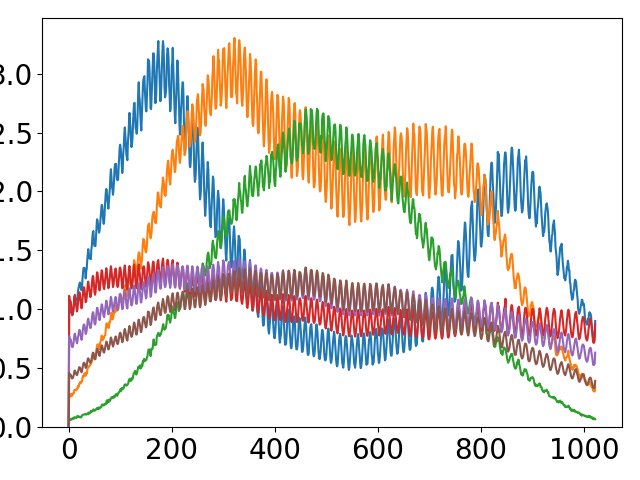

In [184]:
plt.figure()
plt.plot(point_source_bkgsubtr_1B[:,26])
plt.plot(point_source_bkgsubtr_1B[:,27])
plt.plot(point_source_bkgsubtr_1B[:,28])
# plt.plot(degrade[:,26])
# plt.plot(degrade2[:,26])
# plt.plot(degrade3[:,26])
plt.plot(degrade4[:,26])
plt.plot(degrade4[:,27])
plt.plot(degrade4[:,28])
plt.ylim(0)
plt.tight_layout()

<IPython.core.display.Javascript object>


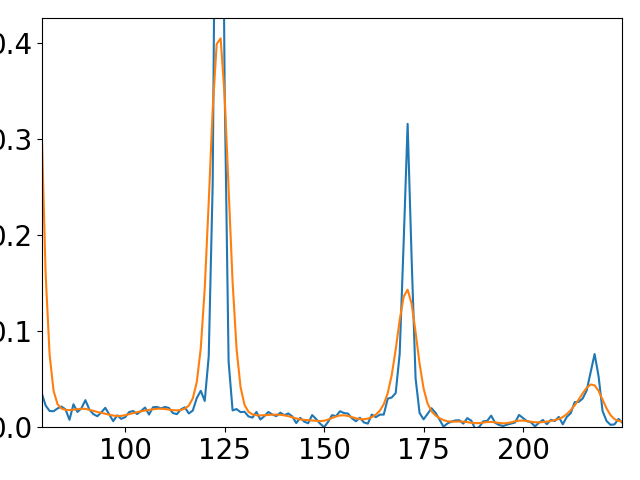

In [181]:
plt.figure()
plt.plot(point_source_bkgsubtr_1B[512,:])
# plt.plot(degrade[512,:])
# plt.plot(degrade2[512,:])
plt.plot(degrade4[512,:])
plt.ylim(0)
plt.tight_layout()

[ 1.08047274  0.97186768  1.0124924   1.1008048   1.79638979  1.29735359]


<IPython.core.display.Javascript object>


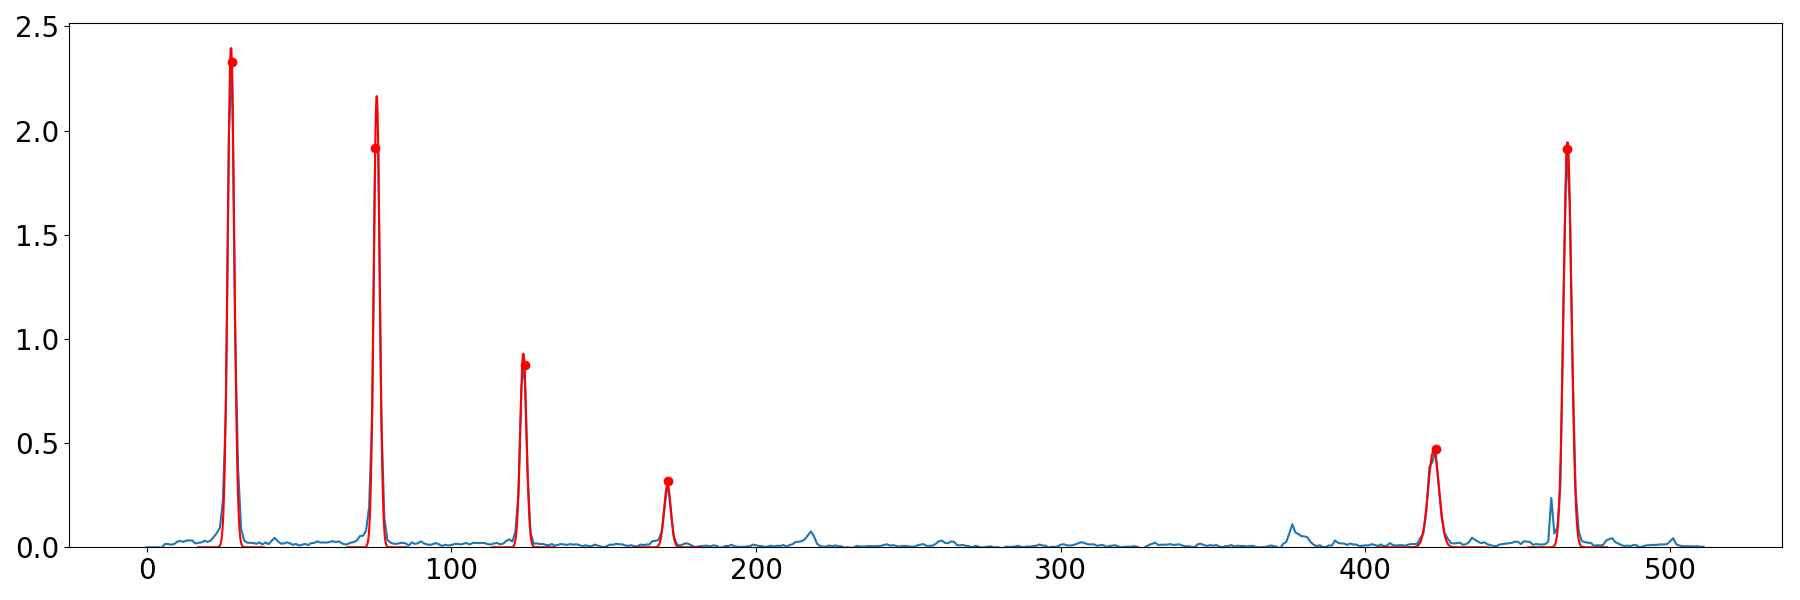

In [107]:
from scipy.optimize import curve_fit
ydata = point_source_bkgsubtr_1B[512,:512]
ydata[np.isnan(ydata)] = 0.
ydata[ydata<0] = 0.
xdata = np.arange(len(ydata))
peaks = funcs.find_peaks(ydata,thres=0.1,min_dist=20)

bounds_gauss = ([0,0,0],[np.inf,np.inf,np.inf])

fitparams = []
fiterrors = []
fitting_flag = []
range_ini = np.full(len(peaks),np.nan) # fit range first position
range_fin = np.full(len(peaks),np.nan) # fit range last position
for i in range(len(peaks)):
    N = 10

    peak_idx = peaks[i]
    
    guess_gauss = [ydata[peak_idx],xdata[peak_idx],1.]
    
    range_ini[i] = xdata[peak_idx-N]
    range_fin[i] = xdata[peak_idx+N]
    popt,pcov = curve_fit(funcs.gauss1d_woBaseline,xdata[peak_idx-N:peak_idx+N],ydata[peak_idx-N:peak_idx+N],p0=guess_gauss,absolute_sigma=True,bounds=bounds_gauss)
    fitting_flag.append('gauss1d')
    
    fitparams.append(popt)
    fiterrors.append(pcov)
    
amplitudes  = funcs.get_amplitude(fitparams,fitting_flag)
linecenters = funcs.get_linecenter(fitparams,fitting_flag)
sigmas      = funcs.get_FWHM(fitparams,fitting_flag)/2.355

print sigmas

plt.figure(figsize=(18,6))
plt.plot(point_source_bkgsubtr_1B[512,:512])
plt.plot(peaks,point_source_bkgsubtr_1B[512,peaks],'ro')
funcs.plot_etalon_fit(fitparams,fitting_flag)
plt.ylim(0)
plt.tight_layout()

In [141]:
all_amps,all_linecens,all_sigmas = [],[],[]
for ypos in [100,200,300,400,500,600,700,900]:
    print ypos
    ydata = point_source_bkgsubtr_3A[ypos,:]
    ydata[np.isnan(ydata)] = 0.
    ydata[ydata<0] = 0.
    xdata = np.arange(len(ydata))
    peaks = funcs.find_peaks(ydata,thres=0.1,min_dist=20)

    bounds_gauss = ([0,0,0],[np.inf,np.inf,np.inf])

    fitparams = []
    fiterrors = []
    fitting_flag = []
    range_ini = np.full(len(peaks),np.nan) # fit range first position
    range_fin = np.full(len(peaks),np.nan) # fit range last position
    for i in range(len(peaks)):
        N = 10

        peak_idx = peaks[i]

        guess_gauss = [ydata[peak_idx],xdata[peak_idx],1.]

        range_ini[i] = xdata[peak_idx-N]
        range_fin[i] = xdata[peak_idx+N]
        popt,pcov = curve_fit(funcs.gauss1d_woBaseline,xdata[peak_idx-N:peak_idx+N],ydata[peak_idx-N:peak_idx+N],p0=guess_gauss,absolute_sigma=True,bounds=bounds_gauss)
        fitting_flag.append('gauss1d')

        fitparams.append(popt)
        fiterrors.append(pcov)

    amplitudes  = funcs.get_amplitude(fitparams,fitting_flag)
    linecenters = funcs.get_linecenter(fitparams,fitting_flag)
    sigmas      = funcs.get_FWHM(fitparams,fitting_flag)/2.355
    
    all_amps.append(amplitudes)
    all_linecens.append(linecenters)
    all_sigmas.append(sigmas)

# plt.figure(figsize=(18,6))
# plt.plot(point_source_bkgsubtr_1B[512,:512])
# plt.plot(peaks,point_source_bkgsubtr_1B[512,peaks],'ro')
# funcs.plot_etalon_fit(fitparams,fitting_flag)
# plt.ylim(0)
# plt.tight_layout()

100
200
300
400
500
600
700
900


In [149]:
# plt.figure(figsize=(12,6))
for i in range(len([100,200,300,400,500,600,700,900])):
    print all_sigmas[i]
#     if len(all_sigmas[i])==6:
#         plt.plot(i,all_sigmas[i][0],'bo')
#         plt.plot(i,all_sigmas[i][1],'ro')
#         plt.plot(i,all_sigmas[i][2],'go')
#         plt.scatter(i,all_sigmas[i][3],c='orange')
#         plt.scatter(i,all_sigmas[i][4],c='magenta')
#         plt.scatter(i,all_sigmas[i][5],c='k')
#     else: continue
# plt.tight_layout()

[ 1.45907266  1.10072023  1.77695648  2.36107685  1.25789287]
[ 1.10751783  1.74769112  2.35344587  1.2405889 ]
[ 1.12816175  1.8239901   2.37149694  1.21031994]
[ 1.11141191  1.67225668  2.36390911  1.19359013]
[ 1.0711226   1.79602205  2.32787562  1.21669062]
[ 1.06750323  1.62890221  2.36742782  1.2394751 ]
[ 1.35948693  1.09551061  1.72229745  2.41757013  1.2901715 ]
[ 1.40486999  1.0903186   1.61090707  2.49193929  1.36775001]


<IPython.core.display.Javascript object>


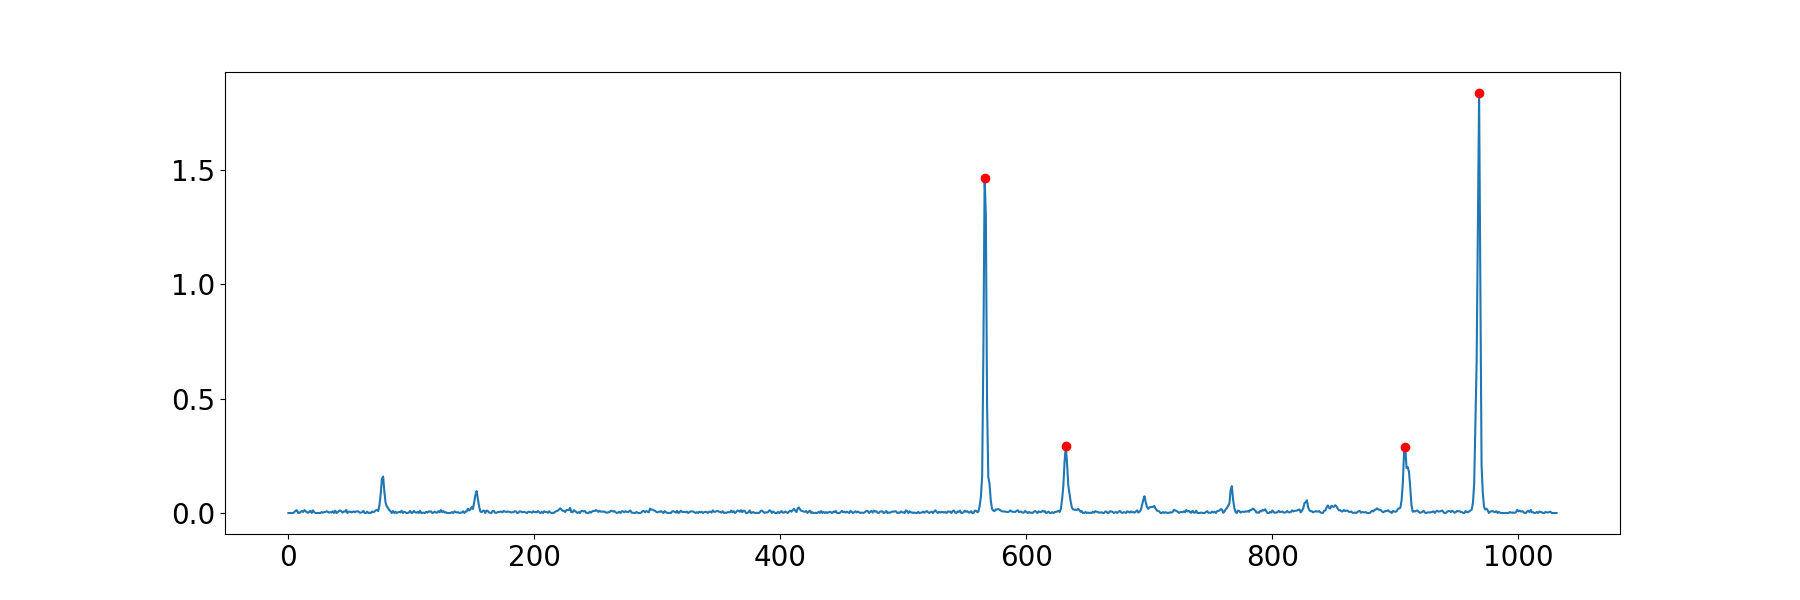

In [140]:
ydata = point_source_bkgsubtr_3A[200,:]
ydata[np.isnan(ydata)] = 0.
ydata[ydata<0] = 0.
xdata = np.arange(len(ydata))
peaks = funcs.find_peaks(ydata,thres=0.1,min_dist=20)

plt.figure(figsize=(18,6))
plt.plot(point_source_bkgsubtr_3A[200,:])
plt.plot(peaks,point_source_bkgsubtr_3A[200,peaks],'ro')

# fitparams = []
# fiterrors = []
# fitting_flag = []
# range_ini = np.full(len(peaks),np.nan) # fit range first position
# range_fin = np.full(len(peaks),np.nan) # fit range last position
# for i in range(len(peaks)):
#     N = 10

#     peak_idx = peaks[i]
    
#     guess_gauss = [ydata[peak_idx],xdata[peak_idx],1.]
    
#     range_ini[i] = xdata[peak_idx-N]
#     range_fin[i] = xdata[peak_idx+N]
#     popt,pcov = curve_fit(funcs.gauss1d_woBaseline,xdata[peak_idx-N:peak_idx+N],ydata[peak_idx-N:peak_idx+N],p0=guess_gauss,absolute_sigma=True,bounds=bounds_gauss)
#     fitting_flag.append('gauss1d')
    
#     fitparams.append(popt)
#     fiterrors.append(pcov)
    
# linecenters = funcs.get_linecenter(fitparams,fitting_flag)
# amplitudes  = funcs.get_amplitude(fitparams,fitting_flag)
# sigmas      = funcs.get_FWHM(fitparams,fitting_flag)/2.355

# print sigmas

# plt.figure(figsize=(18,6))
# plt.plot(point_source_bkgsubtr_3A[512,:])
# plt.plot(peaks,point_source_bkgsubtr_3A[512,peaks],'ro')
# funcs.plot_etalon_fit(fitparams,fitting_flag)
# plt.ylim(0)
# plt.tight_layout()

<IPython.core.display.Javascript object>


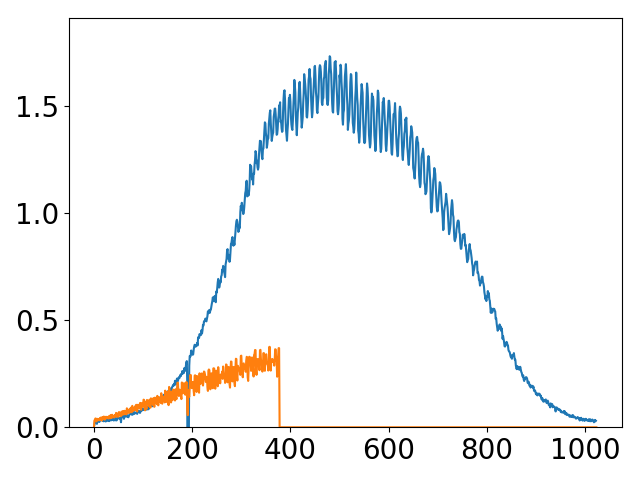

In [33]:
plt.figure()
plt.plot(point_source_bkgsubtr_1B[:,467])
plt.plot(degrade_img[:,467])
plt.ylim(0)
plt.tight_layout()

<IPython.core.display.Javascript object>


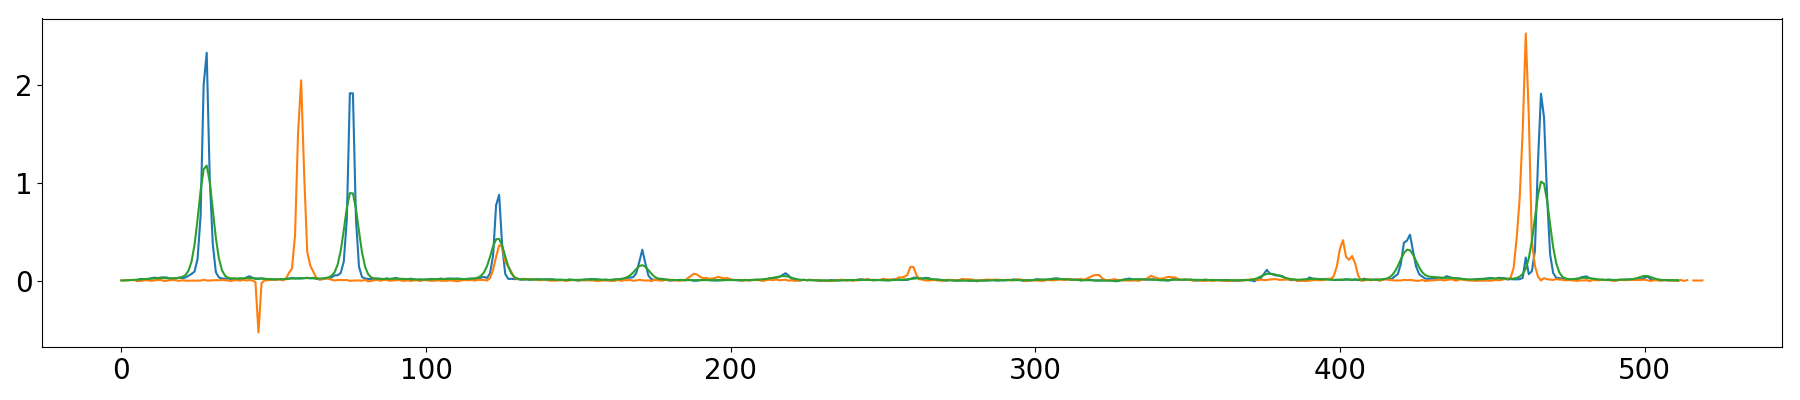

In [66]:
plt.figure(figsize=(18,4))
plt.plot(np.arange(len(point_source_bkgsubtr_1B[512,:512])),point_source_bkgsubtr_1B[512,:512])
plt.plot(np.arange(len(point_source_bkgsubtr_3A[512,512:])),point_source_bkgsubtr_3A[512,512:])
plt.plot(degrade[512,:512])
plt.tight_layout()

In [1]:
psffits_1B = funcs.get_cdps('1B',cdpDir,output='img')[3]
psf_img_1B = funcs.evaluate_psf_cdp(psffits_1B,d2cMaps_1B)

NameError: name 'funcs' is not defined

In [38]:
psffits_3A = funcs.get_cdps('3A',cdpDir,output='img')[3]
# PSF CDP is provided as a spectral cube
#>get values
psf_values = psffits_3A[1].data.transpose(2,1,0) # flip data from Z,Y,X to X,Y,Z

#>get grid
NAXIS1,NAXIS2,NAXIS3 = psf_values.shape

alphastpix   = psffits[1].header['CRPIX1'] # pixel nr
alpha_step   = psffits[1].header['CDELT1'] # arcsec/pix
stalpha      = psffits[1].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec

betastpix    = psffits[1].header['CRPIX2'] # pixel nr
beta_step    = psffits[1].header['CDELT2'] # arcsec/pix
stbeta       = psffits[1].header['CRVAL2']-(betastpix-1)*beta_step # arcsec

stwavl       = psffits[1].header['CRVAL3'] # microns
wavl_step    = psffits[1].header['CDELT3'] # microns/pix

alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)
beta_slices  = np.linspace(stbeta,stbeta+ (NAXIS2-1.5)*beta_step,NAXIS2)
wvl_slices   = np.linspace(stwavl ,stwavl+NAXIS3*wavl_step,NAXIS3)/2.

#> center psf to source
alpha_slices += np.mean(alpha_centers['1B'][~np.isnan(alpha_centers['1B'])])
beta_slices  += np.mean(beta_centers['1B'][~np.isnan(beta_centers['1B'])])

#> create interpolant based on regular grid
interpolpsf = scp_interpolate.RegularGridInterpolator((alpha_slices,beta_slices,wvl_slices),psf_values)
interpolpsf.fill_value=0.
interpolpsf.bounds_error=False

# evaluate psf at each pixel center and pixel corner
alphaULMap = d2cMaps_1B['alphaULMap']
alphaURMap = d2cMaps_1B['alphaURMap']
alphaLLMap = d2cMaps_1B['alphaLLMap']
alphaLRMap = d2cMaps_1B['alphaLRMap']
alphaMap   = d2cMaps_1B['alphaMap']

betaULMap = d2cMaps_1B['betaULMap']
betaURMap = d2cMaps_1B['betaURMap']
betaLLMap = d2cMaps_1B['betaLLMap']
betaLRMap = d2cMaps_1B['betaLRMap']
betaMap   = d2cMaps_1B['betaMap']

lambdaULMap_order2 = d2cMaps_1B['lambdaULMap']
lambdaURMap_order2 = d2cMaps_1B['lambdaURMap']
lambdaLLMap_order2 = d2cMaps_1B['lambdaLLMap']
lambdaLRMap_order2 = d2cMaps_1B['lambdaLRMap']
lambdaMap_order2 = d2cMaps_1B['lambdaMap']

#> interpolate psf to science image pixel centers and corners
#-- assume no significant change in wavelength over one pixel size
psfUL  = interpolpsf((alphaULMap,betaULMap,lambdaULMap_order2))
psfUR  = interpolpsf((alphaURMap,betaURMap,lambdaURMap_order2))
psfLL  = interpolpsf((alphaLLMap,betaLLMap,lambdaLLMap_order2))
psfLR  = interpolpsf((alphaLRMap,betaLRMap,lambdaLRMap_order2))
psfCEN = interpolpsf((alphaMap,betaMap,lambdaMap_order2))

#> evaluate psf as a weighted average
w = np.array([0.125,0.125,0.125,0.125,0.5]) # WARNING: ARBITRARY!
sumweights = w.sum()

psf_img_3A = (w[0]*psfUL+w[1]*psfUR+w[2]*psfLL+w[3]*psfLR+w[4]*psfCEN)/sumweights


In [23]:
for ibin in range(len(lambcens_1B)):
    # map containing only pixels within one spectral bin
    pixelsInBinNoNaN = np.where(np.abs(d2cMaps_1B['lambdaMap']-lambcens_1B[ibin])<lambfwhms_1B[ibin]/2.)
    # enforce normalization of psf in every wavelength bin
    psf_img_1B[pixelsInBinNoNaN] = psf_img_1B[pixelsInBinNoNaN]/psf_img_1B[pixelsInBinNoNaN].sum()
    
for ibin in range(len(lambcens_3A)):
    # map containing only pixels within one spectral bin
    pixelsInBinNoNaN = np.where(np.abs(d2cMaps_3A['lambdaMap']-lambcens_3A[ibin])<lambfwhms_3A[ibin]/2.)
    # enforce normalization of psf in every wavelength bin
    psf_img_3A[pixelsInBinNoNaN] = psf_img_3A[pixelsInBinNoNaN]/psf_img_3A[pixelsInBinNoNaN].sum()

/Users/ioannisa/anaconda2/envs/miricle.20170307/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


In [ ]:
from scipy import signal
test_img = signal.convolve2d(psf_img_1B,psf_img_3A,mode='same')

plt.figure(figsize=(12,5))
plt.plot(psf_img_1B[512,:512])
plt.plot(1+np.arange(512),psf_img_3A[512,:512])
# plt.plot(point_source_bkgsubtr_1B[512,:512])
plt.plot(test_img[512,:512])
plt.hlines(0,0,512)
plt.tight_layout()

<IPython.core.display.Javascript object>


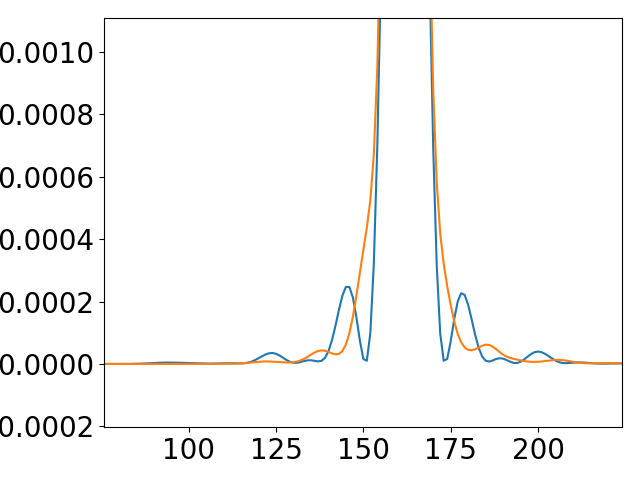

In [50]:
plt.figure()
plt.plot(np.arange(len(psffits_3A[1].data[200,:,:][161,:])),psffits_3A[1].data[200,:,:][161,:])
plt.plot(41+np.arange(len(psffits_1B[1].data[200,:,:][119,:])),psffits_1B[1].data[200,:,:][119,:])
plt.tight_layout()

<IPython.core.display.Javascript object>


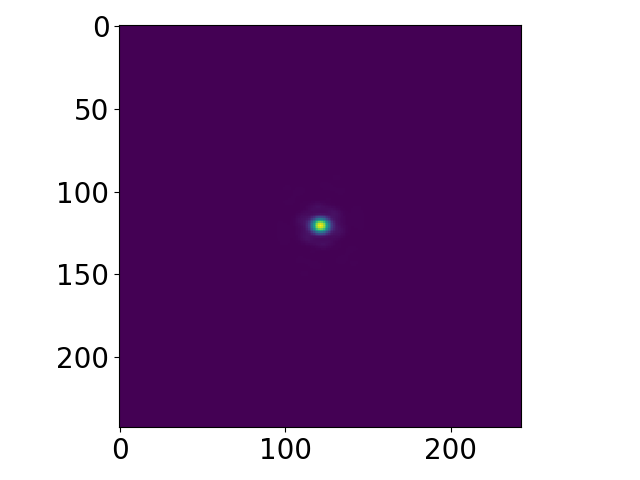

<IPython.core.display.Javascript object>


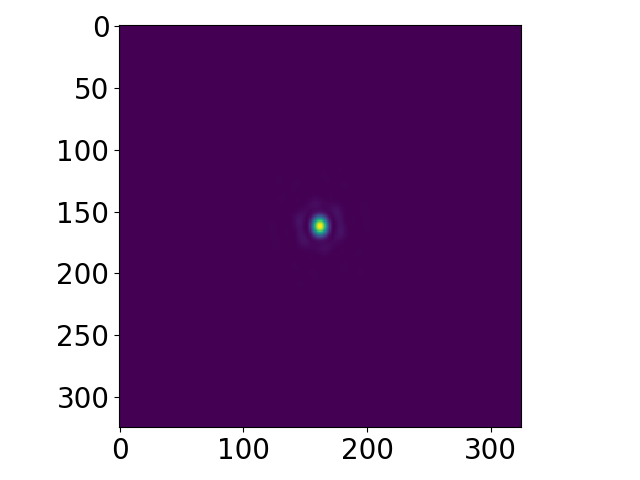

In [51]:
plt.figure()
plt.imshow(psffits_1B[1].data[200,:,:])
plt.tight_layout()
plt.figure()
plt.imshow(psffits_3A[1].data[200,:,:])
plt.tight_layout()